<a href="https://colab.research.google.com/github/NovakMateusz/crispy-sentiment-ml/blob/master/notebooks/IMDB/model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Model selection

In [2]:
!pip install boto3
!pip install scikit-learn==1.2.1

import datetime
import pathlib
import pickle
import uuid
import os

import boto3
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score


plt.rcParams["figure.figsize"] = (16, 8)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Mounting Google Drive and setting up paths

In [3]:
drive.mount('/content/drive')

COLAB_ROOT_DIR = pathlib.Path('.')
DRIVE_ROOT_DIR = COLAB_ROOT_DIR / 'drive/MyDrive'
PROJECT_ROOT_DIR = DRIVE_ROOT_DIR / 'bachelors_dissertation'

DATA_DIR = PROJECT_ROOT_DIR / 'data' / 'clean' / 'IMDB'
MODELS_DIR = PROJECT_ROOT_DIR / 'models'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Constans

In [4]:
LABELS = {
    0: 'Nagative',
    1: 'Positive'
}

BUCKET_NAME = 'sentiment-analysis'

### Load the dataset

In [5]:
dataframe = pd.read_csv(DATA_DIR / 'IMDB_50K_clean.csv')

### Split dataset to train and test sets

In [6]:
%%time

train_set, test_set = train_test_split(dataframe, test_size=0.2, random_state=42)

vectorizer = CountVectorizer(stop_words='english')

train_set_vector = vectorizer.fit_transform(train_set['text'])
test_set_vector = vectorizer.transform(test_set['text'])

CPU times: user 16.1 s, sys: 196 ms, total: 16.3 s
Wall time: 31.7 s


### SGD Classifier

In [7]:
%%time
sgd_model = SGDClassifier()
sgd_model.fit(train_set_vector, train_set['label'])

CPU times: user 1.46 s, sys: 31.4 ms, total: 1.49 s
Wall time: 4.42 s


SGDClassifier()

In [8]:
train_labels_predictions = cross_val_predict(sgd_model, test_set_vector, test_set['label'], cv=3)

print('precision:\t%.3f' % precision_score(test_set['label'], train_labels_predictions))
print('recall:\t\t%.3f' % recall_score(test_set['label'], train_labels_predictions))
print('f1:\t\t%.3f' % f1_score(test_set['label'], train_labels_predictions))

precision:	0.840
recall:		0.840
f1:		0.840


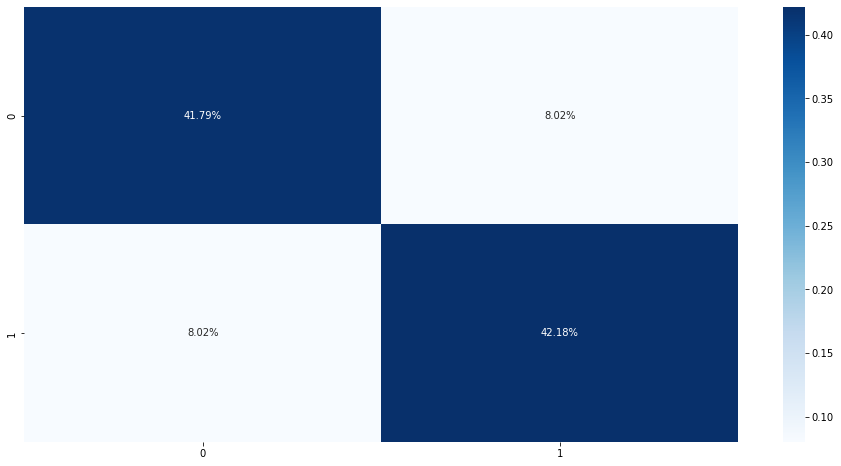

In [9]:
cm = confusion_matrix(test_set['label'], train_labels_predictions)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues');

### Logistic Regression Classifier

In [10]:
%%time

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(train_set_vector, train_set['label'])

CPU times: user 23.2 s, sys: 24.1 s, total: 47.4 s
Wall time: 44.5 s


LogisticRegression(max_iter=1000)

In [11]:
train_labels_predictions = cross_val_predict(lr_model, test_set_vector, test_set['label'], cv=3)

print('precision:\t%.3f' % precision_score(test_set['label'], train_labels_predictions))
print('recall:\t\t%.3f' % recall_score(test_set['label'], train_labels_predictions))
print('f1:\t\t%.3f' % f1_score(test_set['label'], train_labels_predictions))

precision:	0.848
recall:		0.867
f1:		0.858


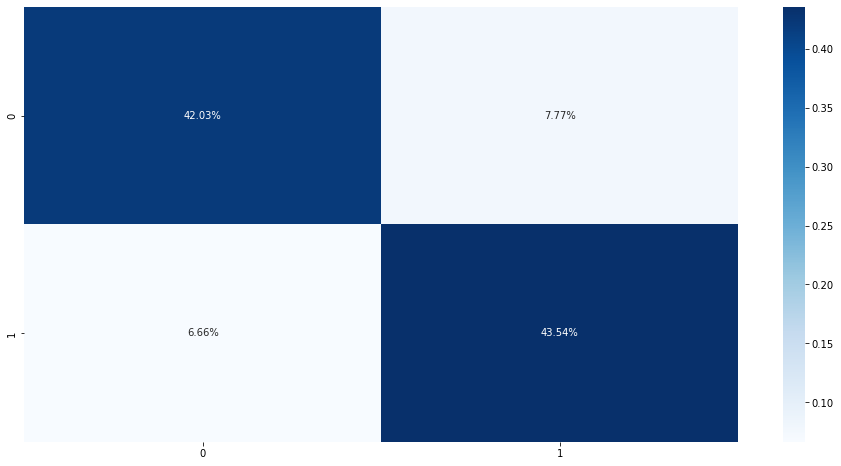

In [12]:
cm = confusion_matrix(test_set['label'], train_labels_predictions)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues');

### Decision Tree Classifier

In [13]:
%%time

model = DecisionTreeClassifier()
model.fit(train_set_vector, train_set['label'])

CPU times: user 1min 36s, sys: 2.12 ms, total: 1min 36s
Wall time: 1min 38s


DecisionTreeClassifier()

In [14]:
train_labels_predictions = cross_val_predict(model, test_set_vector, test_set['label'], cv=3)

print('precision:\t%.3f' % precision_score(test_set['label'], train_labels_predictions))
print('recall:\t\t%.3f' % recall_score(test_set['label'], train_labels_predictions))
print('f1:\t\t%.3f' % f1_score(test_set['label'], train_labels_predictions))

precision:	0.712
recall:		0.712
f1:		0.712


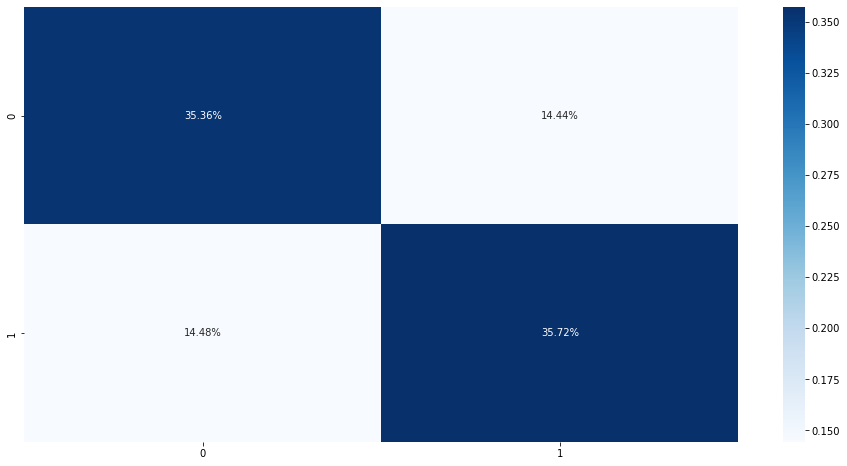

In [15]:
cm = confusion_matrix(test_set['label'], train_labels_predictions)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues');

### Hyperparameter tuning of Logistic Regression model

In [16]:
model = LogisticRegression(max_iter=1000)

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [1.0, 0.5, 0.1, 0.01, 0.001]

grid = dict(solver=solvers, penalty=penalty, C=c_values)
logistic_regression_grid_search = GridSearchCV(estimator=model, param_grid=grid, cv=2, scoring='f1', verbose=3)
logistic_regression_grid_search.fit(train_set_vector, train_set['label']);

Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV 1/2] END C=1.0, penalty=l2, solver=newton-cg;, score=0.877 total time=   8.4s
[CV 2/2] END C=1.0, penalty=l2, solver=newton-cg;, score=0.872 total time=  10.3s
[CV 1/2] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.877 total time=  14.7s
[CV 2/2] END ...C=1.0, penalty=l2, solver=lbfgs;, score=0.872 total time=  11.4s
[CV 1/2] END C=1.0, penalty=l2, solver=liblinear;, score=0.877 total time=   8.6s
[CV 2/2] END C=1.0, penalty=l2, solver=liblinear;, score=0.872 total time=   4.4s
[CV 1/2] END C=0.5, penalty=l2, solver=newton-cg;, score=0.880 total time=   9.0s
[CV 2/2] END C=0.5, penalty=l2, solver=newton-cg;, score=0.875 total time=   7.5s
[CV 1/2] END ...C=0.5, penalty=l2, solver=lbfgs;, score=0.880 total time=  11.0s
[CV 2/2] END ...C=0.5, penalty=l2, solver=lbfgs;, score=0.875 total time=  10.3s
[CV 1/2] END C=0.5, penalty=l2, solver=liblinear;, score=0.880 total time=   5.1s
[CV 2/2] END C=0.5, penalty=l2, solver=li

In [17]:
print(logistic_regression_grid_search.best_params_)

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [18]:
model = LogisticRegression(max_iter=1000, **logistic_regression_grid_search.best_params_)
model.fit(train_set_vector, train_set['label']);

train_labels_predictions = cross_val_predict(model, test_set_vector, test_set['label'], cv=3)

precision = precision_score(test_set['label'], train_labels_predictions)
recall = recall_score(test_set['label'], train_labels_predictions)
f1 = f1_score(test_set['label'], train_labels_predictions)

print('precision:\t%.3f' % precision)
print('recall:\t\t%.3f' % recall)
print('f1:\t\t%.3f' % f1)

precision:	0.853
recall:		0.874
f1:		0.864


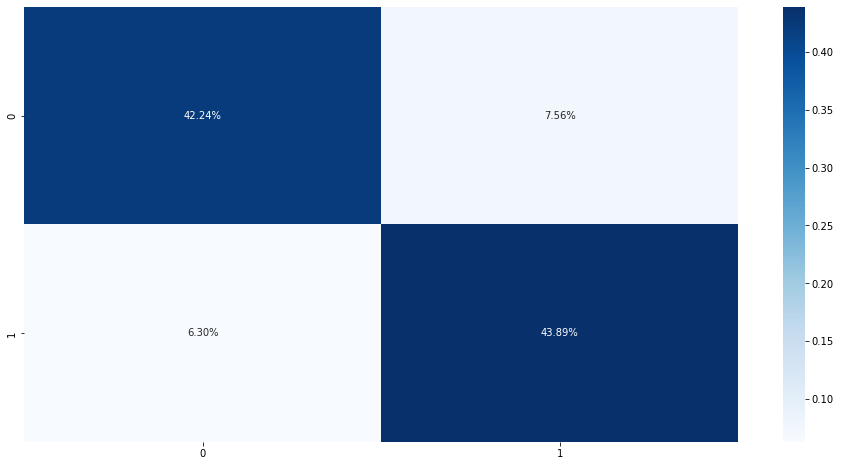

In [19]:
cm = confusion_matrix(test_set['label'], train_labels_predictions)
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues');

### Saving the best model on Google Drive


In [20]:
save_date = datetime.datetime.now().strftime("%Y%m%d")
model_name = 'logistic_regression'
model_hash = uuid.uuid4().hex

output = {
    "model_name": model_name,
    'model_hash': model_hash,
    'labels': LABELS,
    "model": model,
    "vectorizer": vectorizer,
    'metrics': {
        'precision': precision,
        'recal': recall,
        'f1': f1,
      }
    }

with open(MODELS_DIR / f'{model_name}_{save_date}', 'wb') as fp:
  pickle.dump(output, fp)

### Saving the best model on Filebase

In [23]:
s3_client = boto3.client('s3', endpoint_url='https://s3.filebase.com', aws_access_key_id=os.getenv('filebase_access_key_id'), aws_secret_access_key=os.getenv('filebase_secret_access_key'))


with open(MODELS_DIR / f'{model_name}_{save_date}', 'rb') as fp:
  s3_client.upload_fileobj(fp, BUCKET_NAME, model_hash)

### Final model description

In [32]:
print('General info')
print(f'\tModel name:\t{model_name}')
print(f'\tModel hash:\t{model_hash}')
print(f'\tDate:\t\t{datetime.datetime.now()}')
print("Metrics")
print(f'\tPrecision:\t{precision}')
print(f'\tRecall:\t\t{recall}')
print(f'\tf1: \t\t{f1}')

General info
	Model name:	logistic_regression
	Model hash:	4e1181527c9046d58f94b9de76565358
	Date:		2023-03-02 22:23:19.839644
Metrics
	Precision:	0.8530276308054086
	Recall:		0.8744475693049417
	f1: 		0.8636048011110009


### Test model on sample review

In [ ]:
example_review = "Horrible, horrible, horrible I can't believe how miscast this movie is. What was Ed Norton thinking when he signed up for this? Okay, it's a remake. If you saw the first hulk, you don't need to see this one. Feel free to avoid this one. And feel happy that you did."

text_string = vectorizer.transform([example_review])
print(LABELS[model.predict(text_string)[0]])